## 4. Model development

<br>

Last time we used simulations as well as prior and posterior predictive checks to check and improve upon our model for Cepheids in a single galaxy. We then found the `alpha` and `beta` posteriors for each galaxy independently. 

<br>

In order to use the period luminosity relation to extend the cosmic distance ladder, and eventually estimate the Hubble constant, the relation needs be *universal*, i.e. the same `alpha` and `beta` should hold for all galaxies, within uncertainties.  

<br>

From our studies of individual galaxies, we should be able to see the similarities and differences between the results. But, how do we combine these results properly, and keep track of the uncertainties or correlations between parameters?

### Hierarchical models

<br>

A natural way to combine the inidividual galaxy results is to build a **hierarchical model** for all galaxies that we have data for. To understand how to do this, we can start with a simpler example of a simple normal model, like the one we used to understand Stan in the [introduction notebook](introduction.ipynb).

<br>

<img src="figures/hierarchical_model.pdf" alt="Going from a single-level normal model to an hierarchical normal model" width="600"/>

<br>

Imagine that $\mu$ is now sampled from some parent distribution, with mean $\theta$ and standard deviation $\tau$.

<br>

<u>Single-level normal model:</u>
$$
p(\mu, \sigma|x) \propto p(x|\mu, \sigma) p(\mu, \sigma).
$$

<u>Hierarchical normal model</u>:
$$
p(\theta, \tau | x) \propto p(x|\mu, \sigma) p(\sigma) p(\mu | \theta, \tau) p(\theta, \tau)
$$

<br>

Hierarchical models are ideal for describing populations of objects with similar properties, like our Cepheid-hosting galaxies. If we let `alpha` and `beta` for each galaxy come from parent distributions with means `mu_X` and standard deviations `tau_X`, we can then fit for the shape of the universal `alpha` and `beta` distributions!

<br>
 
We see that building up hierarchies in this way can quickly lead to a large number of free parameters, which may seem scary. However, Hamiltonian Monte Carlo is designed to cope with these kind of models, and this should be no problem for Stan.

<br>

>Note: Even though the models we were working with so far often had multiple levels, the relationship between parameters across these levels was purely deterministic (e.g. between m and M). In a true hierarchical model, parameters in the hierarchy have probabilistic relationships.

### A joint hierarchical fit of all galaxies

<br>

**Exercise 1 (10 points):** Sketch the graphical model for our hierarchical model for Cepheids over all galaxies

<br>

A simplified Stan model for the full hierarchy can be found in `cepheid_v3.stan`. Note that this is based on `cepheid_v1.stan`, and you should also incorporate the changes that you made during the exercises in the [model checking notebook](model_checking.ipynb) in order to achieve a good fit to the data. I will use `cepheid_v3.stan` here to demonstrate a few important points about hierarchical modelling.

In [1]:
!cat stan/cepheid_v3.stan

/**
 * Hierarchical model for Cepheid variables
 * - Multiple galaxies
 * - Shared sigma_m
 * - Weakly informative priors
 **/

data {

  /* usual inputs */
  int Ng; // number of Galaxies
  int Nt; // sum(Nc_g)
  
  int gal_id[Nt]; // galaxy id for each entry [1 - 9] 
  vector[Nt] m_obs; // obs apparent mag.
  real sigma_m; // mag uncertainty
  vector[Nt] log10P; // log10(periods/days)
  vector[Ng] z; // redshift of single galaxy

}

transformed data {

  vector[Ng] dL;
  
  /* luminosity distance */
  dL = (3.0e5 * z) / 70.0; // Mpc
  
}

parameters {

  /* parameters of the parent distributions */
  real mu_alpha;
  real<lower=0> tau_alpha;

  real mu_beta;
  real<lower=0> tau_beta;

  /* individual galaxy parameters */
  vector[Ng] alpha;
  vector[Ng] beta;
  
}

transformed parameters {

  vector[Nt] M_true;
  vector[Nt] m_true;

  /* P-L relation */
  M_true = alpha[gal_id] + beta[gal_id] .* log10P;

  /* convert to m */
  m_true = M_true + 5 * log10(dL[gal_id]) + 25;
    
}

mod

A few things worth noting:
* The easiest way to deal with a ragged array structure (different number of Cepheids in each galaxy) in Stan is to flatten the array, and pass a vector with the galaxy IDs.
* We introduce `mu` and `tau` parameters for `alpha` and `beta`, with sensible priors.
* We assume the parent `alpha` and `beta` distributions are independent, as a starting point.
* In a hierarchical model, it is not so clear how to separate the priors and likelihood, the model is more a series of conditional steps.

<br>

Now, let's see how the model performs when fitting out dataset.

In [2]:
import h5py
import numpy as np
import arviz as av
from cmdstanpy import CmdStanModel

In [3]:
# load data
galaxy_info = np.loadtxt("data/galaxies.dat")
cepheid_info = np.loadtxt("data/cepheids.dat")

# compile data from all galaxies
galaxies = [int(ngc_no) for ngc_no in galaxy_info[:, 0]]
data = {int(x[0]):{"z":x[1]} for x in galaxy_info}

for g in galaxies:
    j = np.where(cepheid_info[:, 0] == g)[0]
    data[g]["gal"] = np.array([int(i) for i in cepheid_info[j, 0]])
    data[g]["Nc"] = len(data[g]["gal"])
    data[g]["m_obs"] = cepheid_info[j, 1]
    data[g]["sigma_m"] = cepheid_info[j, 2]
    data[g]["P"] = cepheid_info[j, 3]
    data[g]["delta_logO_H"] = cepheid_info[j, 4]
    data[g]["log10P"] = np.log10(data[g]["P"])

In [4]:
# Select out two galaxies
sel = 2

# prepare Stan input
input_data = {}
input_data["Ng"] = len(galaxies[0:sel])
input_data["Nt"] = sum([data[g]["Nc"] for g in galaxies[0:sel]])
input_data["m_obs"] = np.concatenate([data[g]["m_obs"] for g in galaxies[0:sel]])
input_data["log10P"] = np.concatenate([data[g]["log10P"] for g in galaxies[0:sel]])
input_data["gal_id"] = np.concatenate([np.tile(i, data[g]["Nc"]) 
                                       for i, g in enumerate(galaxies[0:sel])]) + 1
input_data["z"] = galaxy_info.T[1][0:sel]
input_data["sigma_m"] = 0.5

In [5]:
stan_model = CmdStanModel(stan_file="stan/cepheid_v3.stan")

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/fran/projects/BayesianWorkflow/src/notebooks/stan/cepheid_v3


In [6]:
fit = stan_model.sample(data=input_data, chains=4, iter_sampling=1000)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4


We should always check the sampler diagnostics first!

In [7]:
fit.diagnose();

INFO:cmdstanpy:Processing csv files: /var/folders/8d/cyg0_lx54mggm8v350vlx91r0000gn/T/tmpr09dsb_q/cepheid_v3-202108271034-1-wh46aoy8.csv, /var/folders/8d/cyg0_lx54mggm8v350vlx91r0000gn/T/tmpr09dsb_q/cepheid_v3-202108271034-2-0yg0eblw.csv, /var/folders/8d/cyg0_lx54mggm8v350vlx91r0000gn/T/tmpr09dsb_q/cepheid_v3-202108271034-3-onz77cbw.csv, /var/folders/8d/cyg0_lx54mggm8v350vlx91r0000gn/T/tmpr09dsb_q/cepheid_v3-202108271034-4-axis39q5.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
619 of 4000 (15%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

The following parameters had split R-

In [8]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-450.00,0.4900,2.800,-450.000,-450.00,-440.0,33.0,25.0,1.1
mu_alpha,-1.40,0.0580,1.700,-3.800,-1.50,1.5,910.0,680.0,1.0
tau_alpha,2.20,0.1200,2.200,0.670,1.50,6.1,340.0,250.0,1.0
mu_beta,-4.10,0.0290,0.860,-5.300,-4.10,-3.0,880.0,650.0,1.0
tau_beta,0.87,0.0840,1.600,0.039,0.37,3.1,360.0,270.0,1.0
...,...,...,...,...,...,...,...,...,...
m_true[158],28.00,0.0220,0.160,28.000,28.00,29.0,52.0,39.0,1.1
m_true[159],25.00,0.0081,0.070,25.000,25.00,25.0,75.0,56.0,1.1
m_true[160],25.00,0.0083,0.071,25.000,25.00,25.0,72.0,54.0,1.1


Hmmm, it seems something is off. Let's check the trace and pair plots...

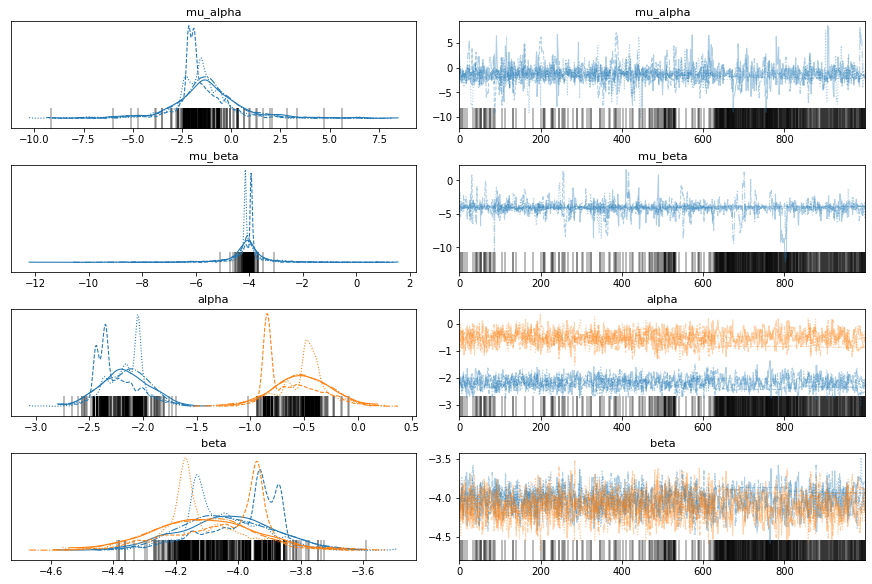

In [9]:
av.plot_trace(fit, var_names=["mu_alpha", "mu_beta", "alpha", "beta"]);

To make a sensibly-sized pair plot and view divergent transitions, we have to pass some more information to `arviz`. Let's focus on the relationship between the `alpha` and `beta` hyperparameters and `M_true` latent parameters for now: 

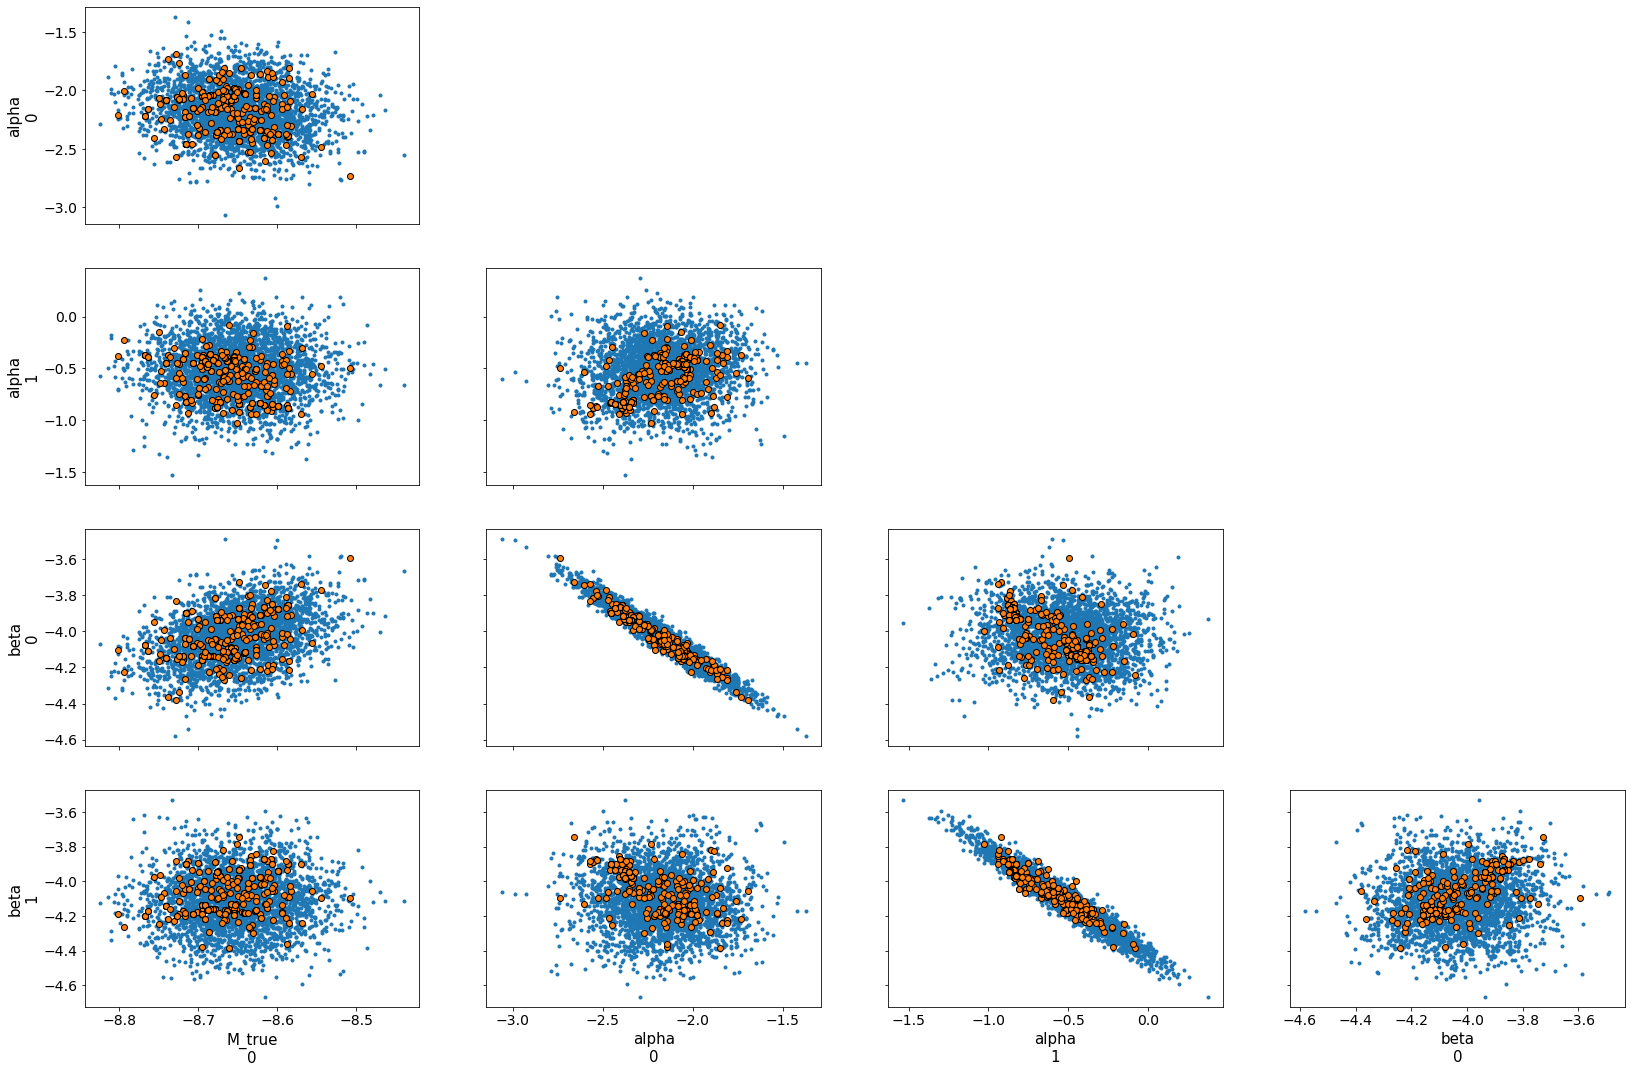

In [10]:
fit_a = av.from_cmdstanpy(fit, coords={"Ng" : np.arange(input_data["Ng"]), 
                                       "Nt" : np.arange(input_data["Nt"])}, 
                             dims={"alpha": ["Ng"], "beta": ["Ng"], "M_true":["Nt"]})
av.plot_pair(fit_a, var_names=["M_true", "alpha", "beta"], 
                divergences=True, coords={"Ng": np.array([0, 1]), 
                                          "Nt": np.array([0])});

The geometry of a hierarchical model with its many latent parameters is much more complex than that of a single model, and divergent transitions can occur. Fortunately, these can be used to help us understand and fix our model.

Here, we can see that the misspecification of the magnitude uncertainty causes problems, although these issues become less servere if we add data from more galaxies, as I'll now demonstrate. It is important to remember that **the geometry the sampler sees depends on both the model and the data**. 

<br>

**Exercise 2 (5 points):** Update the above Stan code with your improvements from the single galaxy case that you carried out in the [model checking notebook](model_checking.ipynb) and display the code. Verify that you can run the above demo with no divergent transitions.

In [11]:
# to be completed...

**Exercise 3 (10 points):** Perform a joint fit of all the galaxies using your improved model, and visualise the posterior predictive distribution of your fit. Can you fit the data well? 

In [12]:
# to be completed...

**Homework exercise 1 (10 points):** Compare the galaxy-level `alpha` and `beta` distributions to those found from individual fits that you completed as part of the [model checking notebook](model_checking.ipynb). What differences can you see?

In [ ]:
# to be completed...

**Homework exercise 2 (20 points):** Make a plot to show how the constraints on the parent distributions for `alpha` and `beta` change depending on the number of galaxies used in the sample. What happens when we only use one or two galaxies?

In [ ]:
# to be completed...

### Estimation of the Hubble constant

<br>

So far we have assumed a value for `H0` in our fits in order to convert between apparent and absolute magnitude. This is necessary to fit for `alpha` and `beta`. Let's think about how we can extend the model to make an estimate of `H0`, rather than assuming it.

<br>

**Exercise 4 (5 points):** What happens if we simply leave `H0` as a free parameter in our existing hierarchical model? Why is this?


In [ ]:
# to be completed...

**Exercise 5 (5 points):** What happens if we change the value of `H0` assumed in our analysis? Which results change, and which stay the same?

In [ ]:
# to be completed...

The Cepheid variable experts that we talked to earlier are impressed with our careful analysis of the period-luminosity relation. They share a new dataset of Cepheid variable stars that are in our own Galaxy, the Milky Way. The distances to these stars are well-measured using geometric methods.

<br>

This dataset is given in `milkyway_cepheids.dat`. It similar to that we have seen before, except that each Cepheid has a distance measurement in kpc. We are also told that the uncertainty in the distance measurements is 150 pc, and that on the apparent magnitudes is 0.1, for all Cepheids. Any effect due to metallicity can be assumed to be negligible here.

<br>

Let's take a look a the data:

In [ ]:
mw_cepheids = np.loadtxt("data/milkyway_cepheids.dat")
d = mw_cepheids.T[0] # distance in kpc
m_obs = mw_cepheids.T[1] # apparent mag
P = mw_cepheids.T[2] # period in days

**Homework exercise 3 (20 points):** Use this new data set to make an independent estimate of `alpha` and `beta`, without assuming `H0`, what do you find?

In [ ]:
# to be completed...

**Homework exercise 4 (20 points):** Update the hierarchical model that you have to include key information from the calibration data into your joint fit. If done correctly, this should allow you to break the degeneracy in the model and directly estimate the Hubble constant. Try to include all relevant uncertainties.

>**Hint**: Assume that `alpha` from the Milky Way dataset is a fair representaion of `mu_alpha`

**Homework exercise 5 (20 points):** What factors affect the uncertainties in your estimate? How could you get a more constrained result?

### Further reading
Hierarchical models: Chapter 5 in [Bayesian data analysis](http://www.stat.columbia.edu/~gelman/book/) by Gelman et al. 